In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
# chunks = pd.read_csv("accepted_2007_to_2018Q4.csv", chunksize=1000_000)

# # Filter to completed loans only
# completed_statuses = [
#     'Fully Paid', 'Charged Off', 'Default',
#     'Late (31-120 days)', 'Late (16-30 days)',
#     'Does not meet the credit policy. Status:Fully Paid',
#     'Does not meet the credit policy. Status:Charged Off'
# ]

# filtered_chunks = []
# attr = []

# for chunk in chunks:
#     columns = chunk.columns
#     if attr:
#         for item in chunk['loan_status'].unique():
#             if item not in attr:
#                 attr.append(item)
#     else:
#         attr = list(chunk['loan_status'].unique())

#     chunk = chunk[chunk['loan_status'].isin(completed_statuses)].copy()
#     filtered_chunks.append(chunk)

# df = pd.concat(filtered_chunks)

# df.sample(400000).to_csv('credit_risk_sample.csv', index=False)

In [3]:
df = pd.read_csv('credit_risk_sample.csv')

print(df.shape)
print(df.sample(8))
print(df.loan_status.value_counts())


(400000, 151)
               id  member_id  loan_amnt  funded_amnt  funded_amnt_inv  \
243781   60636178        NaN     7425.0       7425.0           7425.0   
270965  133829247        NaN     8400.0       8400.0           8400.0   
208782   42763297        NaN    15000.0      15000.0          15000.0   
308692  111105450        NaN    20000.0      20000.0          20000.0   
303719   88684336        NaN    19200.0      19200.0          19200.0   
244973  121366375        NaN    12000.0      12000.0          11750.0   
340644   12465651        NaN    16000.0      16000.0          16000.0   
182126   33641573        NaN    15500.0      15500.0          15500.0   

              term  int_rate  installment grade sub_grade  ...  \
243781   36 months     11.53       244.96     B        B5  ...   
270965   36 months     14.03       287.22     C        C2  ...   
208782   60 months     10.99       326.07     B        B4  ...   
308692   36 months     12.62       670.23     C        C1  ...  

In [4]:
target_map ={
   'Fully Paid':0, 'Charged Off':1, 'Default':1,
    'Late (31-120 days)':1, 'Late (16-30 days)':1,
    'Does not meet the credit policy. Status:Fully Paid':0,
    'Does not meet the credit policy. Status:Charged Off':1
}

In [5]:
df.loan_status.value_counts()

loan_status
Fully Paid                                             313305
Charged Off                                             78375
Late (31-120 days)                                       6237
Late (16-30 days)                                        1281
Does not meet the credit policy. Status:Fully Paid        588
Does not meet the credit policy. Status:Charged Off       205
Default                                                     9
Name: count, dtype: int64

In [6]:
df = df.drop(['id','member_id','title', 'emp_title'],axis=1)

If a variable can change after loan origination, it must be DROPPED.
If it is known at or before application time, it can be KEPT.
So we find potential columns to drop.

In [7]:
leakage_keywords = [
    'pymnt', 'prncp', 'recover', 'rec', 'hardship', 'settlement',
    'last_pymnt', 'next_pymnt', 'collection']

unsafe_date_keywords = [
    "last_", "next_", "_d", "date"
]

leakage_keywords += unsafe_date_keywords

safe_col = ['earliest_cr_line'] + ['pub_rec', 'pub_rec_bankruptcies', 'mths_since_last_record', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq','pymnt_plan']

col_to_drop = [
    col for col in df.columns
    if (
        any(k in col.lower() for k in leakage_keywords)
        and col not in safe_col
    )
]



Of these ones we would like to keep are: `pub_rec, pub_rec_bankruptcies, mths_since_last_record, mths_since_recent_bc, mths_since_recent_bc_dlq, mths_since_recent_inq, mths_since_recent_revol_delinq,pymnt_plan`

In [8]:

print(len(col_to_drop), ' columns to be dropped.')

47  columns to be dropped.


In [9]:
df.drop(col_to_drop, axis=1, inplace=True)

We drop funded_amnt_inv and funded_amnt because these two are highly correlated with loan_amnt.

We also drop url as we do not expect it to have any predictive value.

In [10]:
df.drop(['url','funded_amnt_inv', 'funded_amnt'],axis=1, inplace=True)

We now drop columns with more than 70% missing values.

In [11]:
missing_ratio = df.isna().mean()

drop_missing_cols = missing_ratio[
    missing_ratio > 0.70
].index.tolist()


In [12]:
len(drop_missing_cols)

18

In [13]:
df.drop(drop_missing_cols, axis=1, inplace=True)

In [14]:
df.shape

(400000, 79)

In [15]:
low_variance_cols = []

for col in df.select_dtypes(include=np.number).columns:
    if df[col].nunique() <= 2:
        low_variance_cols.append(col)


In [16]:
low_variance_cols

['policy_code']

In [17]:
df.drop(low_variance_cols, axis=1, inplace=True)

In [18]:
df.zip_code.nunique()

910

In [19]:
df.addr_state.nunique()

51

Both `zip_code, addr_state` are high cardinality categorical variables. We can perform target or frequency encoding for these two.

We will do target for `zip_code` and frequency for 'addr_state'

In [20]:
df.zip_code.isnull().sum()

np.int64(0)

In [21]:
df.shape

(400000, 78)

In [22]:
df.dropna(subset=['zip_code'], inplace=True)

In [23]:
target_map = {
    'Fully Paid': 0, 'Charged Off': 1, 'Default': 1,
    'Late (31-120 days)': 1, 'Late (16-30 days)': 1,
    'Does not meet the credit policy. Status:Fully Paid': 0,
    'Does not meet the credit policy. Status:Charged Off': 1
}
df['loan_status'] = df['loan_status'].map(target_map)

In [24]:
# zip_target = df.groupby("zip_code")["loan_status"].mean()
# df["zip_risk"] = df["zip_code"].map(zip_target)

# df.drop(columns=["zip_code"], inplace=True)

# this will cause target leakage. So we will instead use target encoder with cv

In [25]:
freq = df["addr_state"].value_counts(normalize=True)
df["addr_state_freq"] = df["addr_state"].map(freq)
df.drop(columns=["addr_state"], inplace=True)

`earliest_cr_line` is a date column. It could be more useful if we can transform it into credit_age column which would be a numerical column

In [26]:
df["earliest_cr_line"] = pd.to_datetime(df["earliest_cr_line"], errors="coerce")

df["credit_age_years"] = (
    (pd.to_datetime("today") - df["earliest_cr_line"]).dt.days / 365
)

df.drop(columns=["earliest_cr_line"], inplace=True)


C:\Users\harry\AppData\Local\Temp\ipykernel_33296\74121781.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["earliest_cr_line"] = pd.to_datetime(df["earliest_cr_line"], errors="coerce")


In [27]:
for col in df.columns:
    if df[col].dtype =='object':
        print(col, df[col].nunique())

term 2
grade 7
sub_grade 35
emp_length 11
home_ownership 6
verification_status 3
pymnt_plan 2
purpose 14
zip_code 910
initial_list_status 2
application_type 2
disbursement_method 2


In [28]:
emp_length_map = {
    '< 1 year': 0.5,
    '1 year': 1,
    '2 years': 2,
    '3 years': 3,
    '4 years': 4,
    '5 years': 5,
    '6 years': 6,
    '7 years': 7,
    '8 years': 8,
    '9 years': 9,
    '10+ years': 10,
    'n/a': np.nan
}

df['emp_length_num'] = df['emp_length'].map(emp_length_map)

In [29]:
df['emp_length_num'] = df['emp_length_num'].fillna(
    df['emp_length_num'].median()
)

In [30]:
df.drop(columns=['emp_length'], inplace=True)


In [31]:
df["term_num"] = (
    df["term"]
    .str.extract(r"(\d+)")
    .astype(float)
)

df.drop(columns=["term"], inplace=True)

In [32]:
df.dtypes.value_counts()

float64    67
object     10
int64       1
Name: count, dtype: int64

In [33]:
for col in df.columns:
    if 'fico' in col:
        print(col)

fico_range_low
fico_range_high


In [34]:
df['avg_fico'] = (df.fico_range_low+df.fico_range_high)/2

In [35]:
df.drop('fico_range_high', axis=1, inplace=True)

#### Now we handle missing values in features.
##### We divide features into 4 categories. 

1. Numeric credit features which can be safely imputed with median. eg. Annual Income

2. Numeric Credit variables where missingness carries information. eg. months since recent bank card. 

3. Low cardinality categorical variables like home ownership. Here we replace with "Unknown". Missingness here carries information

4. Columns where missingness carries informatoin eg. emp_length_num but simple imputation is wrong. Instead also add a corresponding missingness column to indicate missing data in this column

#### Category 1

In [36]:
col_2_impute = ['annual_inc', 'revol_bal', 'revol_util','credit_age_years']

from sklearn.impute import SimpleImputer

num_imputer = SimpleImputer(strategy="median")
df[col_2_impute] = num_imputer.fit_transform(df[col_2_impute])

In [37]:
pd.set_option('display.max_rows', None)


df.isnull().sum().sort_index()

acc_open_past_24mths               14550
addr_state_freq                        0
all_util                          236961
annual_inc                             0
application_type                       0
avg_cur_bal                        20577
avg_fico                               0
bc_open_to_buy                     18662
bc_util                            18865
chargeoff_within_12_mths              50
credit_age_years                       0
delinq_2yrs                           10
delinq_amnt                           10
disbursement_method                    0
dti                                  112
emp_length_num                         0
fico_range_low                         0
grade                                  0
home_ownership                         0
il_util                           259034
initial_list_status                    0
inq_fi                            236940
installment                            0
int_rate                               0
loan_amnt       

#### Category 2
Some columns listed below, all encode 'time since' information, which is why they’re often grouped as temporal credit history variables in credit-risk datasets. For these credit variables (NULL = information). For example, mths_since_recent_bc -> Months since most recent bankcard account was opened

Very recent card openings can signal credit-seeking behavior -> slightly higher risk.

So we replace null value with a very large number.

In [38]:
sentinel_cols = [
    "mths_since_recent_bc",
    "mo_sin_old_il_acct",
    "mo_sin_old_rev_tl_op",
    "mo_sin_rcnt_rev_tl_op",
    "mo_sin_rcnt_tl",
    "mths_since_rcnt_il",
    "mths_since_recent_inq",
    "mths_since_recent_revol_delinq"
]

for col in sentinel_cols:
    df[col] = df[col].fillna(999)

In [39]:
df.isna().sum().sort_values(ascending=False).head(10)


il_util         259034
all_util        236961
max_bal_bc      236940
inq_fi          236940
open_rv_24m     236940
open_act_il     236940
total_bal_il    236940
open_acc_6m     236940
total_cu_tl     236940
open_rv_12m     236940
dtype: int64

Above we see some columns have 50% missing values. We we deal with them by imputing them with 0 and add a missing indicator.


#### Strategy: sentinel value + missing indicator

In [40]:
sparse_credit_cols = [
    "il_util", "all_util", "total_cu_tl",
    "open_acc_6m", "open_rv_24m", "open_act_il",
    "open_il_12m", "open_il_24m",
    "total_bal_il", "open_rv_12m", "max_bal_bc", "inq_fi"
]

for col in sparse_credit_cols:
    df[col + "_missing"] = df[col].isna().astype(int)

df[sparse_credit_cols] = df[sparse_credit_cols].fillna(0)

#### Category 3
`home_ownership, verification_status,purpose,application_type` These are low cardinality features where missingness correlates with risk. So we fill NA with 'unknown'

In [41]:
cat_cols = ['home_ownership', 'verification_status','purpose','application_type']

df[cat_cols] = df[cat_cols].fillna("Unknown")

In [42]:
df.isna().sum().sort_values(ascending=False).head(37)

num_tl_120dpd_2m              35523
avg_cur_bal                   20577
num_actv_bc_tl                20567
num_actv_rev_tl               20567
num_accts_ever_120_pd         20567
num_il_tl                     20567
total_rev_hi_lim              20567
num_bc_tl                     20567
tot_cur_bal                   20567
tot_coll_amt                  20567
num_tl_op_past_12m            20567
num_op_rev_tl                 20567
num_rev_tl_bal_gt_0           20567
num_rev_accts                 20567
total_il_high_credit_limit    20567
num_tl_30dpd                  20567
tot_hi_cred_lim               20567
bc_util                       18865
percent_bc_gt_75              18799
bc_open_to_buy                18662
num_bc_sats                   17126
num_sats                      17126
mort_acc                      14550
acc_open_past_24mths          14550
total_bc_limit                14550
total_bal_ex_mort             14550
pub_rec_bankruptcies            412
dti                         

~7–12% missing (≈50k–120k rows)

Fill missing with median

In [43]:
cols_7pct = [
    "num_tl_120dpd_2m", "avg_cur_bal", "num_rev_accts",
    "tot_cur_bal", "total_rev_hi_lim", "tot_hi_cred_lim",
    "num_tl_op_past_12m", "num_tl_30dpd",
    "num_accts_ever_120_pd", "num_actv_bc_tl",
    "num_actv_rev_tl", "total_il_high_credit_limit",
    "num_bc_tl", "num_il_tl", "num_op_rev_tl",
    "num_rev_tl_bal_gt_0", "tot_coll_amt",
    "bc_util", "percent_bc_gt_75", "bc_open_to_buy",
    "num_bc_sats", "num_sats", "acc_open_past_24mths",
    "total_bc_limit", "total_bal_ex_mort", "mort_acc"
]

for col in cols_7pct:
    df[col] = df[col].fillna(df[col].median())

In [44]:
# These are columns like public records, tax liens, chargeoff. Missing value indicates none in the record so can be filled with 0
zero_logical = [
    "chargeoff_within_12_mths",
    "tax_liens",
    "delinq_amnt",
    "pub_rec",
    "pub_rec_bankruptcies",
    "delinq_2yrs"
]

# These are columns where missing does not mean 0. Filling with median seems safer
median_cols = [
     "dti", "total_acc", "open_acc"
]

df[zero_logical] = df[zero_logical].fillna(0)

for col in median_cols:
    df[col] = df[col].fillna(df[col].median())

In [45]:
df.isna().sum().sort_values(ascending=False).head(10)

loan_amnt              0
int_rate               0
installment            0
grade                  0
sub_grade              0
home_ownership         0
annual_inc             0
verification_status    0
loan_status            0
pymnt_plan             0
dtype: int64

In [46]:
high_card = ['grade','sub_grade','home_ownership','purpose']
low_card = ['pymnt_plan', 'initial_list_status','disbursement_method', 'verification_status','application_type']

from sklearn.preprocessing import LabelEncoder

for col in df.columns:
    if col in high_card:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])


df = pd.get_dummies(df, columns=low_card, drop_first=True)

Missing values were handled using domain-specific logic. Highly sparse enhanced bureau features were treated as ‘no activity’ using zero imputation with missingness indicators. Standard bureau snapshot variables were median-imputed to preserve distributional stability, while rare missing values were handled using logical zero or median replacement.

## Baseline model

In [47]:
df.dtypes.value_counts()

float64    67
int64      17
bool        6
object      1
Name: count, dtype: int64

In [48]:
X = df.drop('loan_status', axis=1)
y = df['loan_status']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

print(y_train.mean(), y_test.mean())

0.21526875 0.2152625


In [49]:
from sklearn.preprocessing import TargetEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipeline = [('te',TargetEncoder()),('sc',StandardScaler()),('lr',LogisticRegression(
    penalty="l1",
    solver="liblinear",
    class_weight="balanced",
    max_iter=500,
    C= 0.05))]

pipe = Pipeline(pipeline)

pipe.fit(X_train, y_train)

Pipeline(steps=[('te', TargetEncoder()), ('sc', StandardScaler()),
                ('lr',
                 LogisticRegression(C=0.05, class_weight='balanced',
                                    max_iter=500, penalty='l1',
                                    solver='liblinear'))])

In [50]:
from sklearn.metrics import roc_auc_score

y_pred_proba = pipe.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)

print("Baseline ROC-AUC:", auc)

Baseline ROC-AUC: 0.7211089607726779


Coefficient inspection

In [51]:
log_reg = pipe.named_steps.lr

coef_df = pd.DataFrame({
    "feature": X_train.columns,
    "coef": log_reg.coef_[0]
})


coef_df = coef_df.sort_values("coef", key=np.abs, ascending=False)

In [52]:
coef_df.head(20)

,feature,coef
70,term_num,0.261738
4,sub_grade,0.248189
73,all_util_missing,0.170871
1,int_rate,0.163957
33,acc_open_past_24mths,0.148117
84,pymnt_plan_y,0.147739
43,mort_acc,0.125849
5,home_ownership,0.105424
69,emp_length_num,0.089435
49,num_actv_rev_tl,0.088292


In [53]:
(coef_df["coef"] == 0).mean()

np.float64(0.011111111111111112)

l1 penalty set coefficients of about 2% features to 0

## XGBoost + SHAP

We keep sub_grade, drop grade

sub_grade already contains grade information

Reduces redundancy and noise

In [54]:
X = df.drop(columns=["loan_status", "grade"], errors="ignore")
y = df["loan_status"]

In [55]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [56]:
scale_pos_weight = len(y_train[y_train==0])/len(y_train[y_train==1])

pipeline2 = [('te',TargetEncoder()), ('sc', StandardScaler()), ('xgb', XGBClassifier(
    n_estimators=400,
    max_depth=5,
    min_child_weight=50,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    tree_method="hist",
    eval_metric="auc",
    random_state=42
))]

pipe_xgb = Pipeline(pipeline2)

pipe_xgb.fit(X_train, y_train)


Pipeline(steps=[('te', TargetEncoder()), ('sc', StandardScaler()),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='auc',
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=50, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=400, n_jobs=None,
                               num_parallel_tree=None, ...))])

## Model Evaluation

In [57]:
from sklearn.metrics import roc_auc_score

y_pred_proba = pipe_xgb.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)

print("XGBoost ROC-AUC:", auc)

XGBoost ROC-AUC: 0.7288300263671977


## KS statistic

In [58]:
import numpy as np
from scipy.stats import ks_2samp

ks = ks_2samp(
    y_pred_proba[y_test == 0],
    y_pred_proba[y_test == 1]
).statistic

print("KS:", ks)

KS: 0.33615664498023196


## SHAP: Explainability

In [59]:
import shap

X_test_transformed = pipe_xgb[:-1].transform(X_test.iloc[:500])

model = pipe_xgb.named_steps.xgb


In [60]:
X_test_transformed.shape

(500, 89)

In [61]:
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=X.columns)
X_test_transformed_df.shape

(500, 89)

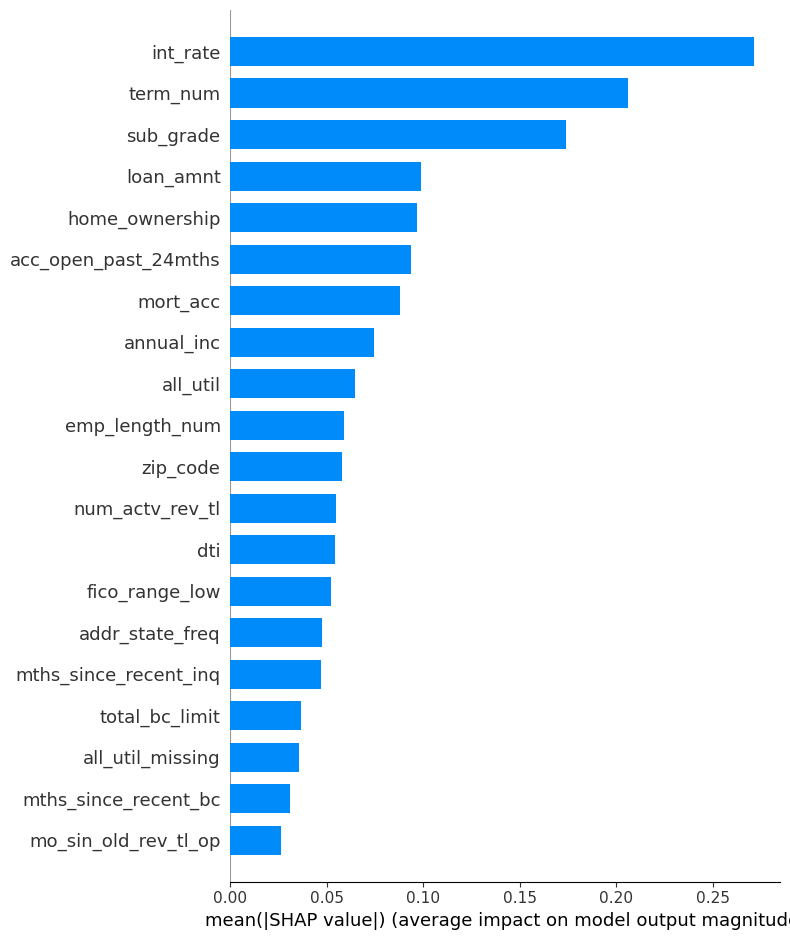

In [62]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_transformed_df)


shap.summary_plot(shap_values, X_test_transformed_df, plot_type='bar')

## Directional Understanding

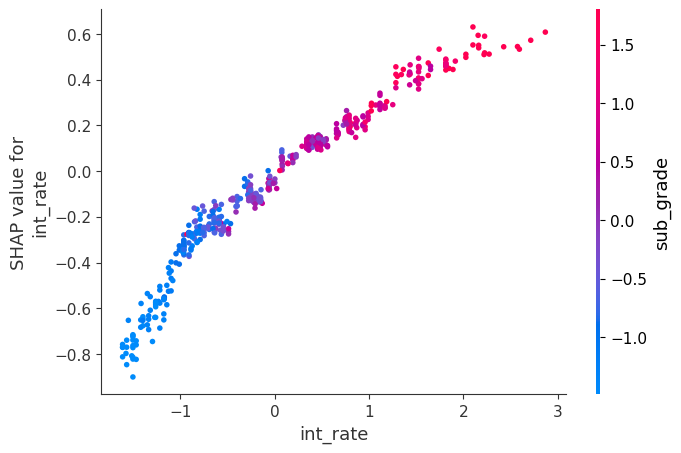

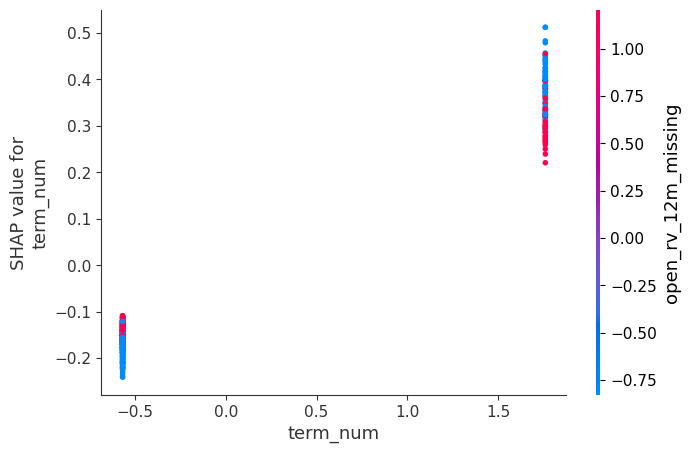

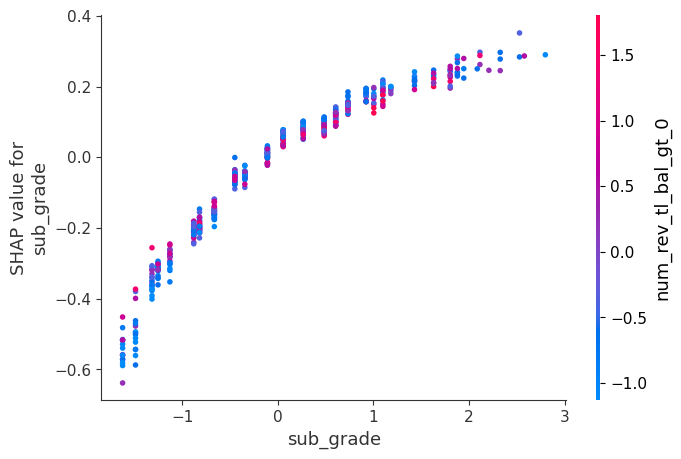

In [63]:
shap.dependence_plot("int_rate", shap_values, X_test_transformed_df)
shap.dependence_plot("term_num", shap_values, X_test_transformed_df)
shap.dependence_plot("sub_grade", shap_values, X_test_transformed_df)


#### Get SHAP values for one loan

In [64]:
i = 42  # loan index

loan = X_test_transformed_df.iloc[[i]]
shap_vals = explainer.shap_values(loan)

In [65]:
loan_shap = (
    pd.DataFrame({
        "feature": loan.columns,
        "value": loan.values[0,:],
        "shap": shap_vals[0,:]
    })
    .sort_values(by = 'shap', key=np.abs, ascending=False)
)


In [66]:
loan_shap.head(10)

,feature,value,shap
1,int_rate,-1.349045,-0.672419
3,sub_grade,-1.316101,-0.391584
32,acc_open_past_24mths,-0.955206,-0.160846
69,term_num,-0.568081,-0.141707
48,num_actv_rev_tl,-1.064089,-0.105243
5,annual_inc,0.337357,0.102904
44,mths_since_recent_inq,-1.766339,-0.072431
10,fico_range_low,-1.490073,-0.071310
4,home_ownership,-0.985660,-0.071242
28,all_util,-0.660143,-0.055720


Let us try to understand above table.

int_rate value is negative means below average so the borrower was offered a relatively low interest rate. This could be because Lender assesed this as low-risk.

sub_grade value is negative means better loan_grade by lender which means lender assessed this as low-risk.

acc_open_past_24mths value is negative which means below average. So not many accounts opened in last 24 months which reflects stable credit behaviour.

term_num value is negative which means a short-term loans. Short-terms loans have relatively lower risk which is reflected in SHAP value.

Almost all strong features push risk DOWN(Because of negative SHAP values)

Only annual income slightly increases risk

Net effect: model sees this as a relatively safer borrower

This borrower is predicted to be low risk primarily due to a low interest rate and strong loan grade, supported by stable credit behavior and manageable repayment obligations. Higher income slightly increases risk, but its impact is negligible compared to the dominant protective factors.

This is because `int_rate, sub_grade, acc_open_past_24mths, term_num` are features having highest impact on SHAP and all have negative SHAP values , ie, reduce risk.

In [67]:
from skopt_hyperparam_tune import *

In [68]:
te = TargetEncoder(
    categories="auto",
    target_type="binary",
    smooth="auto"
)

X_train_te = te.fit_transform(X_train, y_train)

X_test_te = te.transform(X_test)

In [69]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_te)
X_test_scaled = scaler.transform(X_test_te)



In [70]:

X_train_final = pd.DataFrame(
    X_train_scaled,
    columns=X_train.columns,
    index=X_train.index
)

X_test_final = pd.DataFrame(
    X_test_scaled,
    columns=X_test.columns,
    index=X_test.index
)

In [71]:
tune_xgb_credit_risk(X_train_final, y_train, X_test_final, y_test)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 33.6285
Function value obtained: 0.5069
Current minimum: 0.5069
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 65.3618
Function value obtained: 0.6879
Current minimum: 0.5069
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 31.5223
Function value obtained: 0.4934
Current minimum: 0.4934
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 120.8463
Function value obtained: 0.5324
Current minimum: 0.4934
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 78.5632
Function value obtained: 0.7415
Current minimum: 0.4934
Iteration No: 6 started. Eval

(XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=1.0, device=None, early_stopping_rounds=50,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, feature_weights=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.01, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=np.int64(6), max_leaves=None,
               min_child_weight=np.int64(20), missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=2000,
               n_jobs=-1, num_parallel_tree=None, ...),
 {'learning_rate': 0.01,
  'max_depth': np.int64(6),
  'min_child_weight': np.int64(20),
  'subsample': 1.0,
  'colsample_bytree': 1.0,
  'scale_pos_weight': 1.822678047789101},
 0.4893339251391942